## Importing libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

## Loading data

In [2]:
PATH = 'C:/Users/Leo/Desktop/Stuff/Hackathons/UmojaHackZimbabwe/'
train = pd.read_csv(PATH + 'input/Train.csv')
test = pd.read_csv(PATH + 'input/Test.csv')
var_desc = pd.read_csv(PATH + 'input/VariableDefinitions.csv')

In [3]:
pd.set_option('display.max_colwidth', -1)
var_desc

,Loan_ID,A unique ID for this loan
0,Loan Category Code,One of 6 possible loan categories
1,ActualFirstDisbursementDate,​The date of the first loan disbursement
2,ApprovalDate,Date the loan is approved
3,FirstInstalmentDate,Date the first installment is due
4,MaturityDate,Date the loan reaches maturity
5,LoanAmount,Initial amount loaned to customer (values have been scaled and do not reflect dollar amounts)
6,BillingFrequency,The loan billing frequency
7,LoanInterestrate,Interest rate of the loan (values have been scaled and do not reflect real interest rate)
8,NumberOfDependency,Number of persons under customers care
9,OtherLoansBalance,Amount outstanding on other loans held by the customers


## EDA and Preprocessing

In [4]:
train.head()

,Loan_ID,Loan Category Code,ActualFirstDisbursementDate,ApprovalDate,FirstInstalmentDate,MaturityDate,LoanAmount,BillingFrequency,LoanInterestrate,NumberOfDependency,OtherLoansBalance,MaritalStatus,Gender,BirthDate,Target
0,005DTM4,0,2018-12-24,2018-12-28,2019-01-30,2020-12-30,17615.64,Monthly,71.21,3.0,2,Married,Female,Nov 1990,0
1,00E1LTS,0,2019-01-03,2019-01-24,2019-01-30,2020-12-30,12330.92,Monthly,71.21,3.0,1,Married,Male,Nov 1975,0
2,00T6VP0,0,2019-03-29,2019-03-29,2019-04-30,2021-03-30,17967.87,Monthly,71.21,2.0,0,Un-Married,Male,Mar 1966,0
3,00W9TT0,0,2019-02-14,2019-02-27,2019-03-30,2020-08-30,10786.73,Monthly,71.21,3.0,0,Married,Male,Sep 1980,0
4,0115VRN,0,2018-10-29,2018-10-31,2018-11-30,2020-10-30,20257.92,Monthly,71.21,3.0,4,Married,Male,Apr 1969,0


In [5]:
test.head()

,Loan_ID,Loan Category Code,ActualFirstDisbursementDate,ApprovalDate,FirstInstalmentDate,MaturityDate,LoanAmount,BillingFrequency,LoanInterestrate,NumberOfDependency,OtherLoansBalance,MaritalStatus,Gender,BirthDate
0,0060OKE,0,2019-05-29,2019-05-31,2019-06-30,2020-05-30,14374.33,Monthly,71.21,3.0,1,Married,Male,Apr 1967
1,00LTNOZ,1,2019-06-24,2019-06-28,2019-07-30,2020-06-30,19764.81,Monthly,82.17,3.0,0,Un-Married,Female,Feb 1970
2,00YK1YB,0,2019-04-15,2019-04-15,2019-05-30,2021-04-30,11679.09,Monthly,71.21,NaN,0,Married,Female,Sep 1971
3,0131KT1,0,2018-10-11,2018-10-19,2018-11-30,2020-10-30,4403.91,Monthly,71.21,1.0,1,Un-Married,Female,Oct 1982
4,01ML49H,0,2019-02-15,2019-02-27,2019-03-30,2020-02-29,17978.01,Monthly,71.21,1.0,1,Married,Male,Jul 1976


In [6]:
train.shape, test.shape

((8315, 15), (4282, 14))

In [7]:
train.dtypes

Loan_ID                        object 
Loan Category Code             int64  
ActualFirstDisbursementDate    object 
ApprovalDate                   object 
FirstInstalmentDate            object 
MaturityDate                   object 
LoanAmount                     float64
BillingFrequency               object 
LoanInterestrate               float64
NumberOfDependency             float64
OtherLoansBalance              int64  
MaritalStatus                  object 
Gender                         object 
BirthDate                      object 
Target                         int64  
dtype: object

In [8]:
train.isnull().sum(), test.isnull().sum()

(Loan_ID                        0   
 Loan Category Code             0   
 ActualFirstDisbursementDate    0   
 ApprovalDate                   0   
 FirstInstalmentDate            0   
 MaturityDate                   0   
 LoanAmount                     0   
 BillingFrequency               0   
 LoanInterestrate               0   
 NumberOfDependency             1044
 OtherLoansBalance              0   
 MaritalStatus                  0   
 Gender                         0   
 BirthDate                      0   
 Target                         0   
 dtype: int64,
 Loan_ID                        0  
 Loan Category Code             0  
 ActualFirstDisbursementDate    0  
 ApprovalDate                   0  
 FirstInstalmentDate            0  
 MaturityDate                   0  
 LoanAmount                     0  
 BillingFrequency               0  
 LoanInterestrate               0  
 NumberOfDependency             559
 OtherLoansBalance              0  
 MaritalStatus                  0 

In [9]:
train = train.fillna(-9999)
test = test.fillna(-9999)

Text(0.5, 1.0, 'Target Distribution')

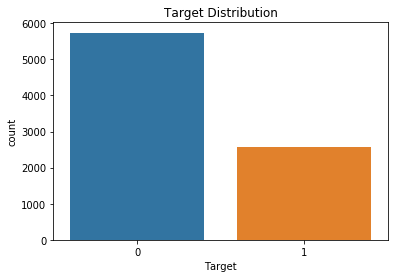

In [10]:
sns.countplot(data=train, x='Target').set_title('Target Distribution')

In [11]:
#sns.countplot(data=train, x='MaritalStatus', hue='Target')

In [12]:
#sns.countplot(data=train, x='Gender', hue='Target')

## Feature Engineering 

In [13]:
# Extracting date features
train['ActualFirstDisbursementDate'] = pd.to_datetime(train["ActualFirstDisbursementDate"].str.split().str[0])
train['dis_year'] = train['ActualFirstDisbursementDate'].dt.year
train['dis_month'] = train['ActualFirstDisbursementDate'].dt.month
train['dis_day'] = train['ActualFirstDisbursementDate'].dt.day

train['ApprovalDate'] = pd.to_datetime(train["ApprovalDate"].str.split().str[0])
train['app_year'] = train['ApprovalDate'].dt.year
train['app_month'] = train['ApprovalDate'].dt.month
train['app_day'] = train['ApprovalDate'].dt.day

train['FirstInstalmentDate'] = pd.to_datetime(train["FirstInstalmentDate"].str.split().str[0])
train['first_year'] = train['FirstInstalmentDate'].dt.year
train['first_month'] = train['FirstInstalmentDate'].dt.month
train['first_day'] = train['FirstInstalmentDate'].dt.day

train['MaturityDate'] = pd.to_datetime(train["MaturityDate"].str.split().str[0])
train['mat_year'] = train['MaturityDate'].dt.year
train['mat_month'] = train['MaturityDate'].dt.month
train['mat_day'] = train['MaturityDate'].dt.day

test['ActualFirstDisbursementDate'] = pd.to_datetime(test["ActualFirstDisbursementDate"].str.split().str[0])
test['dis_year'] = test['ActualFirstDisbursementDate'].dt.year
test['dis_month'] = test['ActualFirstDisbursementDate'].dt.month
test['dis_day'] = test['ActualFirstDisbursementDate'].dt.day

test['ApprovalDate'] = pd.to_datetime(test["ApprovalDate"].str.split().str[0])
test['app_year'] = test['ApprovalDate'].dt.year
test['app_month'] = test['ApprovalDate'].dt.month
test['app_day'] = test['ApprovalDate'].dt.day

test['FirstInstalmentDate'] = pd.to_datetime(test["FirstInstalmentDate"].str.split().str[0])
test['first_year'] = test['FirstInstalmentDate'].dt.year
test['first_month'] = test['FirstInstalmentDate'].dt.month
test['first_day'] = test['FirstInstalmentDate'].dt.day

test['MaturityDate'] = pd.to_datetime(test["MaturityDate"].str.split().str[0])
test['mat_year'] = test['MaturityDate'].dt.year
test['mat_month'] = test['MaturityDate'].dt.month
test['mat_day'] = test['MaturityDate'].dt.day

In [14]:
# log transform loan amount
train['log_loan'] = np.log(train['LoanAmount'])
test['log_loan'] = np.log(test['LoanAmount'])

In [15]:
# additional date features
train['birth_year'] = train['BirthDate'].str.split(n = 1, expand = True)[1]
train['birth_year'] = train['birth_year'].astype('int64')
train['Tenure'] = train['MaturityDate']  - train['ActualFirstDisbursementDate']
train['Tenure'] = train['Tenure'] /np.timedelta64(1,'D')
train['processing'] = train['ApprovalDate']  - train['ActualFirstDisbursementDate']
train['processing'] = train['processing'] /np.timedelta64(1,'D')

test['birth_year'] = test['BirthDate'].str.split(n = 1, expand = True)[1]
test['birth_year'] = test['birth_year'].astype('int64')
test['Tenure'] = test['MaturityDate']  - test['ActualFirstDisbursementDate']
test['Tenure'] = test['Tenure'] /np.timedelta64(1,'D')
test['processing'] = test['ApprovalDate']  - test['ActualFirstDisbursementDate']
test['processing'] = test['processing'] /np.timedelta64(1,'D')

In [16]:
# additional features
train['f1'] = train.groupby(['mat_year'])['OtherLoansBalance'].transform('mean')
train['f2'] = train.groupby(['mat_year'])['Loan Category Code'].transform('mean')

test['f1'] = test.groupby(['mat_year'])['OtherLoansBalance'].transform('mean')
test['f2'] = test.groupby(['mat_year'])['Loan Category Code'].transform('mean')

In [17]:
encorder = LabelEncoder()
train['MaritalStatus'] = encorder.fit_transform(train['MaritalStatus'])
train['Gender'] = encorder.fit_transform(train['Gender'])

test['MaritalStatus'] = encorder.fit_transform(test['MaritalStatus'])
test['Gender'] = encorder.fit_transform(test['Gender'])

In [18]:
train.head()

,Loan_ID,Loan Category Code,ActualFirstDisbursementDate,ApprovalDate,FirstInstalmentDate,MaturityDate,LoanAmount,BillingFrequency,LoanInterestrate,NumberOfDependency,...,first_day,mat_year,mat_month,mat_day,log_loan,birth_year,Tenure,processing,f1,f2
0,005DTM4,0,2018-12-24,2018-12-28,2019-01-30,2020-12-30,17615.64,Monthly,71.21,3.0,...,30,2020,12,30,9.776542,1990,737.0,4.0,1.423469,0.782313
1,00E1LTS,0,2019-01-03,2019-01-24,2019-01-30,2020-12-30,12330.92,Monthly,71.21,3.0,...,30,2020,12,30,9.419865,1975,727.0,21.0,1.423469,0.782313
2,00T6VP0,0,2019-03-29,2019-03-29,2019-04-30,2021-03-30,17967.87,Monthly,71.21,2.0,...,30,2021,3,30,9.796340,1966,732.0,0.0,1.813578,0.383417
3,00W9TT0,0,2019-02-14,2019-02-27,2019-03-30,2020-08-30,10786.73,Monthly,71.21,3.0,...,30,2020,8,30,9.286072,1980,563.0,13.0,1.423469,0.782313
4,0115VRN,0,2018-10-29,2018-10-31,2018-11-30,2020-10-30,20257.92,Monthly,71.21,3.0,...,30,2020,10,30,9.916301,1969,732.0,2.0,1.423469,0.782313


## Model building

In [19]:
# Creating folds. Using StratifiedKFold with 10 folds
train['kfold'] = -1
train = train.sample(frac=1).reset_index(drop=True)
kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train,y=train.Target.values)):
    train.loc[val_idx, 'kfold'] = fold

In [20]:
features = [f for f in train.columns if f not in ("Loan_ID", "Target", "kfold", "BirthDate", "ActualFirstDisbursementDate", 
                                               "ApprovalDate", "FirstInstalmentDate", "MaturityDate", "BillingFrequency")]

### 1. Catboost

In [21]:
folds_predictions = pd.DataFrame()
#runs each fold and evaluate the model
def run(fold):
    train_train = train[train.kfold != fold].reset_index(drop=True)
    train_valid = train[train.kfold == fold].reset_index(drop=True)

    X_train, X_valid = train_train[features].values, train_valid[features].values
    y_train, y_valid = train_train.Target.values, train_valid.Target.values

    # defining model
    model = CatBoostClassifier(iterations=1500, learning_rate=0.01,depth=7,
                          bootstrap_type='Bernoulli',subsample=0.9,
                          eval_metric='AUC',metric_period=20,
                          allow_writing_files=False, verbose=False)
    
    #fitting model
    model.fit(X_train, y_train,eval_set=(X_valid,y_valid))

    #predictions for evaluation
    preds = model.predict_proba(X_valid)[:, 1]

    # evaluation
    auc = roc_auc_score(y_valid, preds)
    print(f"Fold={fold}, AUC={auc}")
    
    #fold predictions
    final_predictions = model.predict_proba(test[features])[:, 1]
    folds_predictions[fold]  = final_predictions

In [22]:
run(fold=0)
run(fold=1)
run(fold=2)
run(fold=3)
run(fold=4)
run(fold=5)
run(fold=6)
run(fold=7)
run(fold=8)
run(fold=9)

Fold=0, AUC=0.8543000297112605
Fold=1, AUC=0.8272357723577235
Fold=2, AUC=0.8599721794560139
Fold=3, AUC=0.8547051832644572
Fold=4, AUC=0.8551238419360938
Fold=5, AUC=0.8417549044862321
Fold=6, AUC=0.8556921867161973
Fold=7, AUC=0.8301427622391845
Fold=8, AUC=0.8266923358505404
Fold=9, AUC=0.8628913081793408


In [23]:
#catboost predictions 
preds = folds_predictions.mean(axis=1)
sub1 =pd.DataFrame({'Loan_ID': test['Loan_ID']})
sub2 = pd.DataFrame ({'Target' :preds})
submission = pd.concat([sub1, sub2], axis ='columns')  
submission.to_csv(PATH + "catboost_final.csv", index=False)

### 2. Xgboost

In [24]:
folds_predictions = pd.DataFrame()
tes = test.drop(["Loan_ID", "BirthDate", "ActualFirstDisbursementDate", 
                    "ApprovalDate", "FirstInstalmentDate", "MaturityDate", "BillingFrequency"],1)
def run(fold):
    df_train = train[train.kfold != fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)

    X_train, X_valid = df_train[features].values, df_valid[features].values
    y_train, y_valid = df_train.Target.values, df_valid.Target.values

    # defining model
    model = XGBClassifier(n_jobs=-1,max_depth=7,n_estimators=140)

    #fitting model
    model.fit(X_train, y_train)

    # predictions for evaluation 
    preds = model.predict_proba(X_valid)[:, 1]

    # evaluation
    auc = roc_auc_score(y_valid, preds)
    print(f"Fold={fold}, AUC={auc}")

    tes.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 
                    'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21','f22', 'f23', 'f24']
    #fold predictions
    final_predictions = model.predict_proba(tes)[:, 1]
    folds_predictions[fold]  = final_predictions

In [25]:
run(fold=0)
run(fold=1)
run(fold=2)
run(fold=3)
run(fold=4)
run(fold=5)
run(fold=6)
run(fold=7)
run(fold=8)
run(fold=9)

Fold=0, AUC=0.8442927369473029
Fold=1, AUC=0.8180050239040597
Fold=2, AUC=0.847567728168976
Fold=3, AUC=0.8479796342813926
Fold=4, AUC=0.8517273046484617
Fold=5, AUC=0.8383926029365908
Fold=6, AUC=0.8490557084559173
Fold=7, AUC=0.8182187936387424
Fold=8, AUC=0.8198558819940618
Fold=9, AUC=0.8515638769506095


In [26]:
#xgboost predictions
xgb_preds = folds_predictions.mean(axis=1)
sub1 =pd.DataFrame({'Loan_ID': test['Loan_ID']})
sub2 = pd.DataFrame ({'Target' :xgb_preds})
submission = pd.concat([sub1, sub2], axis ='columns')  
submission.to_csv(PATH + "xgb_final.csv", index=False)

## Combining models

In [27]:
catb = pd.read_csv(PATH + 'catboost_final.csv')
xgb = pd.read_csv(PATH + 'xgb_final.csv')

In [28]:
final_preds = catb['Target']*0.5 + xgb['Target']*0.5

In [29]:
#submission
final_sub1 =pd.DataFrame({'Loan_ID': catb['Loan_ID']})
final_sub2 = pd.DataFrame ({'Target' :final_preds})
final_submission = pd.concat([final_sub1, final_sub2], axis ='columns')  
final_submission.to_csv(PATH + "final_submission.csv", index=False)  